In [1]:
import numpy as np
import plotly.graph_objects as go
from itertools import combinations
from operator import concat
import igraph
import Surfaces
import TwoMapper
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
    MapperInteractivePlotter,
    nerve
)
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from functools import reduce

from Giotto2Mapper import (two_dim_nerve, two_mapper)

## Circular Cover

Currently, with `giotto-tda` there is only one cover option which is the `gtda.mapper.CubicalCover`. This cover is generated as cartesian products of intervals. A consquence of this is that when taking a filter $f\colon X\to \mathbb{R}^2$ with `CubicalCover` is that there are oppurtunities for **4-fold** intersections, and **not 3-fold intersections**. This means `Giotto2Mapper.two_dim_nerve` in its current state is finding 4-fold intersections and marking them as 3-fold intersections. This is not ideal, and so we should use a different cover structure to find distinct 3-fold intersections when covering the image of our dataset under our filter $f(X)\subseteq\mathbb{R}^2$.

We will go ahead and construct such a cover. This cover will be a 'circular cover' where each open set in the cover is a circle centered on a trianglular lattice. The resulting overlapping circles will have [this appearence](https://en.wikipedia.org/wiki/Overlapping_circles_grid#Triangular_grid_of_overlapping_circles).

#### We first have a triangular lattice.
We will use this triangluar lattice as our base point for constructing our cover. We will also begin to only work with the 'uniform' option of cover where each open set in the cover is the same size.


1. **COMPLETE** Properly shift the lattice to cover $f(X)$.
2. **COMPLETE** Construct lattice to have specified number of bins and correct gain (percentage overlap).
3. **COMPLETE** Make sure output matches the format in the `giotto-tda` files `gtda.mapper.cover.py`.
4. **COMPLETE** Make the test file.
#### TO DO:
5. (optional) Extend circular cover for $n$-dimensional filters where $n>2$ (This is probably quite challenging).
6. (optional) Create a 'balanced' option for the circular cover.

In [7]:
from CircularCover import CircularCover

In [8]:
data = np.array(Surfaces.sample_g2torus(1000))
torus_graph = Surfaces.graph_sample(data)

In [9]:
# Define filter function – can be any scikit-learn transformer
filter_func = Projection(columns=[0, 1])
# Define cover
cover = CircularCover(n_intervals=10, overlap_frac=0.5)
# Choose clustering algorithm – default is DBSCAN
clusterer = DBSCAN()

In [10]:
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=DBSCAN(),
    verbose=False,
    n_jobs=1,
    store_edge_elements=True
)

In [11]:
graph = pipe.fit_transform(data)

In [12]:
fig = plot_static_mapper_graph(pipe, data, layout_dim=3)
fig.show()

In [13]:
two_fig = two_mapper(graph, fig)

In [14]:
two_fig.show()

## How does this cover work?
The following is a code overview of how the triangular lattice is fit over our filtered data set.

In [15]:
filtered_data = filter_func.transform(data)
# Data stats and params
xmin = np.min(filtered_data[:,0])
xmax = np.max(filtered_data[:,0])
ymin = np.min(filtered_data[:,1])
ymax = np.max(filtered_data[:,1])
gain = 0.1
n_intervals = 10

# Find radius r and interval lengths xl and yl
xl = (xmax - xmin)/n_intervals
yl = float((np.sqrt(3)/2)*xl)
radius = (0.5+gain)*xl

'We need two seperate mesh grids for even and odd rows'
even_rows = np.arange(xmin-0.5*xl, xmax+0.5*xl, xl)
even_cols = np.arange(ymin, ymax+yl, 2*yl)
odd_rows = np.arange(xmin, xmax+xl, xl)
odd_cols = np.arange(ymin+yl, ymax+yl, 2*yl)
' We then can construct a mesh grid of each for our triangle lattice centers '
'WE DONT NEED MESHGRID'
xeven, yeven = np.meshgrid(even_rows,even_cols)
xodd, yodd = np.meshgrid(odd_rows, odd_cols)

In [29]:
# Construct the meshgrid as a list of tuples
# Order the list by norm
even_center_list = np.vstack(list(zip(xeven.ravel(),yeven.ravel())))
odd_center_list = np.vstack(list(zip(xodd.ravel(),yodd.ravel())))
center_list = np.concatenate((even_center_list,odd_center_list), axis=0)
sorted_index = np.argsort(np.linalg.norm(center_list, axis=1))
center_list = center_list[sorted_index]

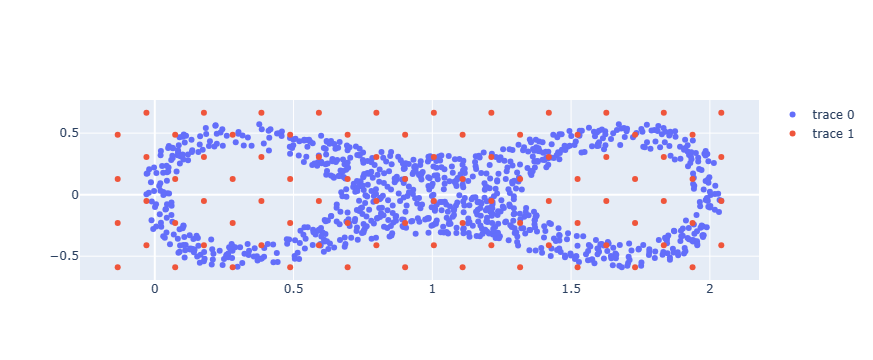

In [26]:
'Plot the cover circle centers'
fig = go.Figure()
fig.add_trace(go.Scatter(x=filtered_data[:,0],y=filtered_data[:,1],mode='markers'))
fig.add_trace(go.Scatter(x=center_list[:,0], y=center_list[:,1], mode='markers'))

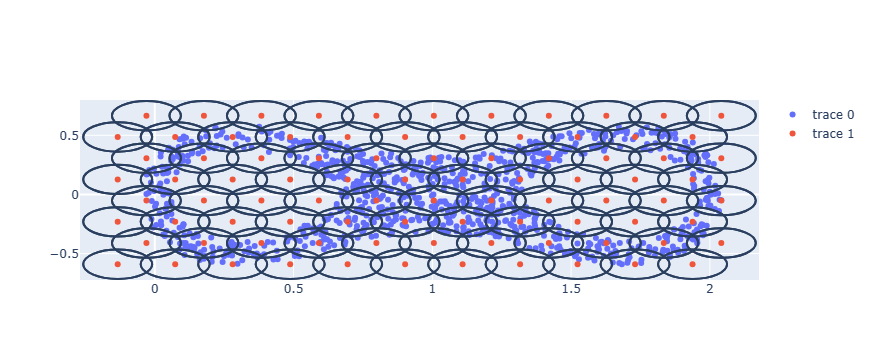

In [31]:
' Plot the cover circles ' 
for point in center_list:
    fig.add_shape(type='circle', x0=point[0]-radius,x1=point[0]+radius,
                  y0=point[1]-radius,y1=point[1]+radius)
fig.show()

The class removes empty balls in the cover.